$$Coursework- Natural Language Processing$$

$$ Submitted By : Arjoo Gupta  (6657774) $$

This notebook is intent to deliver Name Entity Recognization for Restaurant booking chatbot. Dataset For NER has been downloaded from kaggle in json format directly and processed further with actual datset from github according to the requiremnets.

Link for dataset for having NER : https://www.kaggle.com/datasets/swapnilpote/restaurant-chatbot-dataset-intent-entity

In [82]:
#### Importing Required Libraries 
import json
import csv
import string
import operator
import random
import re
import warnings
import bs4 as bs
import urllib.request
import nltk
import re

import opendatasets as od
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from prettytable import PrettyTable

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, GlobalMaxPooling1D, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

from nltk.corpus import wordnet

from keras import layers
from keras import optimizers
from tensorflow.keras import optimizers
from keras.models import Model
from keras.models import Input

In [2]:
### Filtering out warnings
warnings.filterwarnings('ignore')

In [3]:
## Getting dataset directly from kaggle
od.download("https://www.kaggle.com/datasets/swapnilpote/restaurant-chatbot-dataset-intent-entity", force=True)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username:

  arjoogupta


Your Kaggle Key:

  ································


100%|██████████| 119k/119k [00:00<00:00, 2.34MB/s]

In [91]:
### loading dataset
with open ('/home/studio-lab-user/restaurant-chatbot-dataset-intent-entity/restaurant_intent_entities.json', 'r') as f:
    data_json = json.load(f)

In [92]:
### converting dataset in required csv format and writing in .csv file
def trim_json(data_json):
    list1=[]
    
    for key,value in data_json.items():
        for k,v in value.items():
            list1 = v.copy()
    return list1

header = []
data_1 = trim_json(data_json)
list2=[]
list3=[]
j=0
for i in data_1:
    j=j+1
    for c in i['entities']:
        list2.append(j)
        list2.append(i['text'])
        list2.append(c['entity'])
        list2.append(c['value'])
        list3.append(list2)
        list2=[]
with open ('/home/studio-lab-user/restaurant-chatbot-dataset-intent-entity/restaurant_intent_entities.csv', 'w') as csv_f:
    csvwriter=csv.writer(csv_f)
    csvwriter.writerow(['sent#','text','entity','value'])
    csvwriter.writerows(list3)
csv_f.close()

In [93]:
### Loading csv formated dataset
data = pd.read_csv('/home/studio-lab-user/restaurant-chatbot-dataset-intent-entity/restaurant_intent_entities.csv')
data.head()

,sent#,text,entity,value
0,1,book The Middle East restaurant in IN for noon,restaurant_name,The Middle East
1,1,book The Middle East restaurant in IN for noon,restaurant_type,restaurant
2,1,book The Middle East restaurant in IN for noon,state,IN
3,1,book The Middle East restaurant in IN for noon,timeRange,noon
4,2,Book a table at T-Rex distant from Halsey St.,restaurant_name,T-Rex


As per above data, column 'sent#' represent the sentence number corresponding to each sentence from a conversation. 'Text' represents the sentence, 'Entity' represent tag type captured inside the sentence and 'value' represnts the actual word corresponding to the tag type.

### 1. Analysing and Visualising Dataset

In [94]:
##Columns of data
data.columns

Index(['sent#', 'text', 'entity', 'value'], dtype='object')

In [95]:
##Shape of data
data.shape

(6418, 4)

In [96]:
###data information
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6418 entries, 0 to 6417
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   sent#   6418 non-null   int64 
 1   text    6418 non-null   object
 2   entity  6418 non-null   object
 3   value   6418 non-null   object
dtypes: int64(1), object(3)
memory usage: 200.7+ KB


In [97]:
#####checking null values in formated dataset
np.sum(data.isnull())

sent#     0
text      0
entity    0
value     0
dtype: int64

In [98]:
print("No. of sentences in the data: {:,}".format(data["sent#"].nunique()))
print("No. of unique words in the data: {:,}".format(data["value"].nunique()))
print("No. of entities in the data: {:,}".format(data["entity"].nunique()))

No. of sentences in the data: 1,973
No. of unique words in the data: 2,316
No. of entities in the data: 14


In [99]:
###entity counts corresponding to words
data['entity'].value_counts()

restaurant_type           1364
party_size_number         1025
timeRange                  674
state                      519
city                       513
country                    356
restaurant_name            339
spatial_relation           324
party_size_description     317
served_dish                270
cuisine                    211
sort                       203
facility                   160
poi                        143
Name: entity, dtype: int64

<AxesSubplot:>

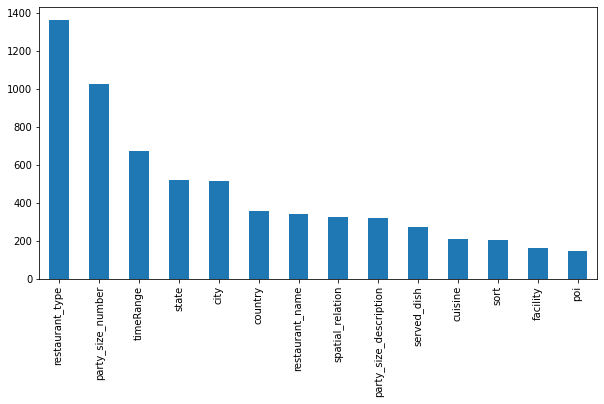

In [100]:
### Entity representation wrt the count 
data["entity"].value_counts().plot(kind="bar", figsize=(10,5), x='entity')

<AxesSubplot:ylabel='entity'>

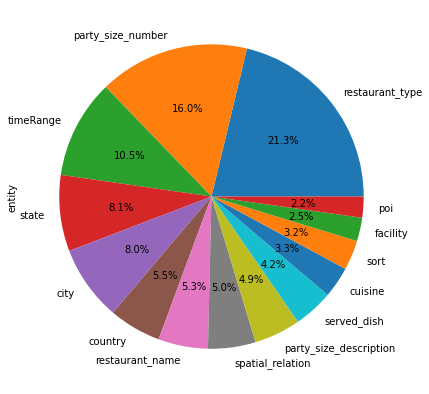

In [101]:
## Entity distribution pie chart for dataset
data["entity"].value_counts().plot(kind = 'pie', autopct='%1.1f%%', figsize=(7, 7))

"restaurant_type" entity contains 21.3% part of dataset while entity like "facility" or "poi" do have distribution as low as 2% only.This might result in biased prediction after training feeding our data to models.

array([[<AxesSubplot:title={'center':'Value distribution in dataset'}>]],
      dtype=object)

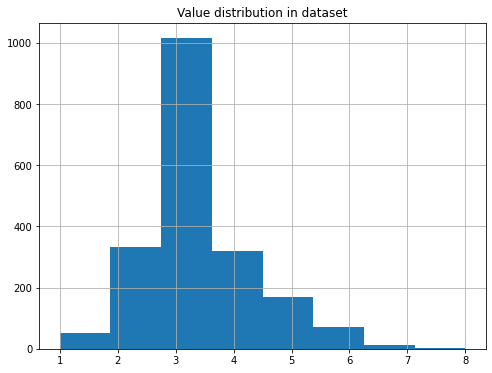

In [102]:
### Distribution plot of words as per distribution
count = data.groupby("sent#")["value"].agg(["count"])
count = count.rename(columns={"count": "Value distribution in dataset"})
count.hist(bins=8, figsize=(8,6))

In [103]:
### Longest sentence in dataset and sent# for that sentence
long_sent = count.max()[0]
long_sent_id = count[count["Value distribution in dataset"]==long_sent].index[0]
print("Longest sentence in dataset contains {} words.".format(long_sent))
print("sent# corresponding to the longest sentence is {}.".format(long_sent_id))

Longest sentence in dataset contains 8 words.
sent# corresponding to the longest sentence is 1198.


## Name Entity Recognition(NER)

#### Choice of Modeling/ Algorithms:

Here I am comparing two different types of LSTM (Long Short Term Memory networks) model. LSTM is a type of Recurrent Neural Network (RNN) only designed to handle the Long term dependencies. I am going to compare the performance of LSTM and BiLSTM on our entity recognition. While LSTM only preserves information from the past, BiLSTM can run your inputs from both sides, i.e. from past to future and future to past as-well.

As per the defination, I am predicting that BiLSTM will provide better results as compared to LSTM, because it will be able to understand entity context better for classification due to having information from both past and future. Also, we have implemented time distributed wrapper layer with Bi-LSTM which simplifies network and provides 2 major things as described below:

1. It frames problem as it is defined and learn accordingly, which means that it maps one input to one output.
2. It simplifies the network such that one step will be processed at a time, which also requries less weights compared to lstm without time-distributed layer.
 
Below I have implemented both models and compared the results for better view:

### 1. BiLSTM (Bidirectional Long Short Term Moemory) Model with Time Distributed Outer Layer:

#### 1.1. Data pre-processing:

In [104]:
###converting data values and entities into list
list_values = list(set(data["value"].values)) 
list_entities= list(set(data["entity"].values))

In [105]:
### removing punctuations from data values
list_values = [s.translate(string.punctuation) for s in list_values]
list_entities = [s.translate( string.punctuation) for s in list_entities]

### Ref: https://stackoverflow.com/questions/4371231/removing-punctuation-from-python-list-items

In [106]:
### importing stop words from sklearn
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS as sklearn_stop_words

print(f"number of sklearn stopwords: {len(sklearn_stop_words)}")

#### importing stop words from nltk
import nltk
stop_words = nltk.corpus.stopwords.words('english')
print(f"number of nltk stopwords: {len(stop_words)}")

## merging nltk stopswords with sklearn stopwards to have a bigger list of stopwords
for elem in sklearn_stop_words:
    stop_words.append(elem)
print(f"number of merged stopwords: {len(stop_words)}")
print(stop_words[:10])

number of sklearn stopwords: 318
number of nltk stopwords: 179
number of merged stopwords: 497
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]


In [107]:
##removing stop-words
data_values = [x for x in list_values if x not in stop_words]
print(f"Data values before removing stopwords: {len(list_values)}")
print(f"Data values after removing stopwords: {len(data_values)}")
data_entities = [x for x in list_entities if x not in stop_words]
print(f"Data entities before removing stopwords: {len(list_entities)}")
print(f"Data entities after removing stopwords: {len(data_entities)}")

Data values before removing stopwords: 2316
Data values after removing stopwords: 2301
Data entities before removing stopwords: 14
Data entities after removing stopwords: 14


#### 1.2. Text Featurisation/Transformation into numerical vectors

##### Integer Encoding:

In [108]:
### Encoding entities and corresponding values using WordEmbedding
value2index = {value: idx for idx, value in enumerate(list_values)}
index2value = {idx: value for value, idx in value2index.items()}

In [109]:
##looking for first 10 encoded values from dictionary
for a,b in sorted(value2index.items(), key=operator.itemgetter(1))[:10]:
    print(a,b)

Lexington Av-53rd St 0
Coney Island Hot Dog Stand 1
Maid-Rite Sandwich Shop 2
Climax Springs 3
Boon Brick Store 4
9 AM 5
fisn'n chips 6
tavern 7
two 8
Lumpkin 9


In [110]:
### testing the logic for word encoding mapping
test = "Japan"

test_id = value2index[test]
test_value = index2value[test_id]

print("The index of the value {} is {}.".format(test, test_id))
print("The value with index {} is {}.".format(test_id, test_value))

The index of the value Japan is 2289.
The value with index 2289 is Japan.


In [111]:
### Now, encoding similiarly for entity aswell
entity2index = {entity: idx for idx, entity in enumerate(list_entities)}
index2entity = {idx: word for word, idx in entity2index.items()}

In [112]:
### testing the logic for entity encoding mapping
test = "restaurant_type"

test_id = entity2index[test]
test_value = index2entity[test_id]

print("The index of the entity {} is {}.".format(test, test_id))
print("The entity with index {} is {}.".format(test_id, test_value))

The index of the entity restaurant_type is 0.
The entity with index 0 is restaurant_type.


In [113]:
###creating corpus of words and entities
def corpus(data):
    z = zip(data["value"].values.tolist(),
            data["entity"].values.tolist())
    return [(value,entity) for value,entity in z]

s = data.groupby("sent#").apply(corpus).tolist()

print(s[0])

[('The Middle East', 'restaurant_name'), ('restaurant', 'restaurant_type'), ('IN', 'state'), ('noon', 'timeRange')]


In [114]:
### Extracting list of values and entities from above corups
X = [[x[0] for x in m] for m in s]
Y = [[y[1] for y in m] for m in s]
print("X[2]:", X[2])
print("Y[2]:", Y[2])

X[2]: ['taverna', 'chili con carne', '10']
Y[2]: ['restaurant_type', 'served_dish', 'party_size_number']


In [115]:
##indexing the list for value and entities
X = [[value2index[x] for x in m] for m in X]
Y = [[entity2index[x] for x in m] for m in Y]
print("X[3]:", X[3])
print("Y[3]:", Y[3])

X[3]: [449, 2289, 2290, 2262]
Y[3]: [12, 1, 8, 2]


#### One-hot Encoding:

We are implementing one-hot encoding for our entity class to convert each column in binary format from integer because BiLSTM  treats higher number more important than lower numbers. Since, our entities do not have any relationship with each other and are independent, then this bias based on integer values will also generate bias results. Hence, converting into one-hot encoding format.

In [116]:
count = len(entity2index)
Y = [ np.eye(count)[s] for s in Y]
print("Count:",count)
print("X[0]:", X[0])
print("Y[0]:", Y[0])

Count: 14
X[0]: [1810, 428, 534, 811]
Y[0]: [[0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


We are going to implement LSTM model for which inputs needs to be in similar size and shape and hence we are applying padding to our labels.

In [117]:
### applying padding
X = pad_sequences(X)
Y = pad_sequences(Y)

In [118]:
## for feeding to model simple, converting dataset into numpy array 
X = np.array(X)
Y = np.array(Y)

#### 1.3. Dataset Splitting

Since, the dataset do have only 1973 sentences and 2316 unique words I needed to divide the dataset in a way with sufficient proportion to train our model corresponding to each entity. Hence, going to experiment with 70%-30% proportion and 90%-10% proportion to compare the results from training models. Also for validating the model, I will further going to divide training dataset in 80%-20% for 70% proportion and 90%-10% for 90% proportion.

In [119]:
###Spliting dataset in proportion of 70%/30% for train/test
X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.3, random_state=1234)

print("No. of sentence in training data: {}".format(len(X_train)))
print("No. of sentence in the test data : {}".format(len(X_test)))

No. of sentence in training data: 1381
No. of sentence in the test data : 592


#### 1.4. Model Implementation with 70%-30% | train/test ratio and 90%-10% | train/validation ratio

In [120]:
tf.random.set_seed(0)
wc = len(value2index)
dense = 50
units = 50
do_lstm = 0.1
units_d = 14

In [121]:
ip_layer = layers.Input(shape=(long_sent,))

model = layers.Embedding(wc, dense, embeddings_initializer="uniform", input_length=long_sent)(ip_layer)

model = layers.Bidirectional(layers.LSTM(units, recurrent_dropout=do_lstm, return_sequences=True))(model)

model = layers.TimeDistributed(layers.Dense(units_d, activation="relu"))(model)

final_model = Model(ip_layer, model)

opt = optimizers.Adam(learning_rate=0.001)

final_model.compile(optimizer=opt, loss='mean_squared_error', metrics=['accuracy'])

final_model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 8)]               0         
                                                                 
 embedding_5 (Embedding)     (None, 8, 50)             115800    
                                                                 
 bidirectional_3 (Bidirectio  (None, 8, 100)           40400     
 nal)                                                            
                                                                 
 time_distributed_3 (TimeDis  (None, 8, 14)            1414      
 tributed)                                                       
                                                                 
Total params: 157,614
Trainable params: 157,614
Non-trainable params: 0
_________________________________________________________________


In [122]:
history = final_model.fit(X_train, y_train, batch_size=50, epochs=30, validation_split=0.1, verbose=2)

Epoch 1/30
25/25 - 6s - loss: 0.0273 - accuracy: 0.4848 - val_loss: 0.0251 - val_accuracy: 0.4281 - 6s/epoch - 221ms/step
Epoch 2/30
25/25 - 0s - loss: 0.0246 - accuracy: 0.4956 - val_loss: 0.0226 - val_accuracy: 0.6052 - 382ms/epoch - 15ms/step
Epoch 3/30
25/25 - 0s - loss: 0.0209 - accuracy: 0.5407 - val_loss: 0.0181 - val_accuracy: 0.5980 - 374ms/epoch - 15ms/step
Epoch 4/30
25/25 - 0s - loss: 0.0163 - accuracy: 0.5145 - val_loss: 0.0142 - val_accuracy: 0.6511 - 374ms/epoch - 15ms/step
Epoch 5/30
25/25 - 0s - loss: 0.0130 - accuracy: 0.7197 - val_loss: 0.0120 - val_accuracy: 0.7041 - 375ms/epoch - 15ms/step
Epoch 6/30
25/25 - 0s - loss: 0.0103 - accuracy: 0.7800 - val_loss: 0.0103 - val_accuracy: 0.7878 - 367ms/epoch - 15ms/step
Epoch 7/30
25/25 - 0s - loss: 0.0077 - accuracy: 0.8589 - val_loss: 0.0092 - val_accuracy: 0.7968 - 370ms/epoch - 15ms/step
Epoch 8/30
25/25 - 0s - loss: 0.0054 - accuracy: 0.9131 - val_loss: 0.0086 - val_accuracy: 0.8741 - 375ms/epoch - 15ms/step
Epoch 9/30

#### 1.5. Choice of Loss function and Optimiser

Loss Function: I have used Mean Squared Error loss function for implementing BiLSTM becuase this loss function ensures that the model does not have any huge outlier prediction which could result in wrong entity recognition.

Optimiser : Used Adam because it combines the best characteristics of AdaGrad and RMSprop optimisers. And these both optimisers are very good for large dataset. Plus point with Adam is also that it uses less memory and is also very efficient with multi-label classification. 

#### 1.6. Hyperparameter Optimisation:

Learning Rate : A value of 0.001 is used for learning rate with Adam optimiser. With small learning rate or alpha the model will give less but betterlearning with each epochs as compared to large learning rate and less epcohs. Alas since our dataset is not that huge, large learning rate will not able to learn more efficiently.

Epochs: I have tested with large epochs and found that the accuracy and loss became constant after completing about 15 epcohs, so kept it for 20.

Batch Size : Batch size is kept small becuase the training data is not too large as-well and the learning rate is also kept small.

#### 1.7. Model Implementation with 90%/10% | train/test ratio and 70%/30% | train/validation ratio

In [123]:
###Spliting dataset in proportion of 90%/10% for train/test
X_train1, X_test1, y_train1, y_test1 = train_test_split(X,Y, test_size=0.1, random_state=1234)

print("Number of sentences in the training dataset: {}".format(len(X_train1)))
print("Number of sentences in the test dataset : {}".format(len(X_test1)))

Number of sentences in the training dataset: 1775
Number of sentences in the test dataset : 198


In [124]:
ip_layer1 = layers.Input(shape=(long_sent,))

model1 = layers.Embedding(wc, dense, embeddings_initializer="uniform", input_length=long_sent)(ip_layer1)

model1 = layers.Bidirectional(layers.LSTM(units, recurrent_dropout=do_lstm, return_sequences=True))(model1)

model1 = layers.TimeDistributed(layers.Dense(units_d, activation="relu"))(model1)

final_model1 = Model(ip_layer1, model1)

opt1 = optimizers.Adam(learning_rate=0.001)

final_model1.compile(optimizer=opt1, loss='mean_squared_error', metrics=['accuracy'])

final_model1.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 8)]               0         
                                                                 
 embedding_6 (Embedding)     (None, 8, 50)             115800    
                                                                 
 bidirectional_4 (Bidirectio  (None, 8, 100)           40400     
 nal)                                                            
                                                                 
 time_distributed_4 (TimeDis  (None, 8, 14)            1414      
 tributed)                                                       
                                                                 
Total params: 157,614
Trainable params: 157,614
Non-trainable params: 0
_________________________________________________________________


In [125]:
history1 = final_model1.fit(X_train1, y_train1, batch_size=50, epochs=30, validation_split=0.3, verbose=2)

Epoch 1/30
25/25 - 4s - loss: 0.0275 - accuracy: 0.3791 - val_loss: 0.0250 - val_accuracy: 0.2045 - 4s/epoch - 178ms/step
Epoch 2/30
25/25 - 0s - loss: 0.0246 - accuracy: 0.4215 - val_loss: 0.0224 - val_accuracy: 0.4170 - 438ms/epoch - 18ms/step
Epoch 3/30
25/25 - 0s - loss: 0.0209 - accuracy: 0.5089 - val_loss: 0.0185 - val_accuracy: 0.5678 - 416ms/epoch - 17ms/step
Epoch 4/30
25/25 - 0s - loss: 0.0169 - accuracy: 0.6256 - val_loss: 0.0152 - val_accuracy: 0.6386 - 416ms/epoch - 17ms/step
Epoch 5/30
25/25 - 0s - loss: 0.0137 - accuracy: 0.6369 - val_loss: 0.0132 - val_accuracy: 0.5668 - 400ms/epoch - 16ms/step
Epoch 6/30
25/25 - 0s - loss: 0.0112 - accuracy: 0.7141 - val_loss: 0.0115 - val_accuracy: 0.7568 - 391ms/epoch - 16ms/step
Epoch 7/30
25/25 - 0s - loss: 0.0085 - accuracy: 0.7934 - val_loss: 0.0102 - val_accuracy: 0.8016 - 393ms/epoch - 16ms/step
Epoch 8/30
25/25 - 0s - loss: 0.0060 - accuracy: 0.8833 - val_loss: 0.0092 - val_accuracy: 0.8804 - 391ms/epoch - 16ms/step
Epoch 9/30

For 90%/10% train/test split, accuracy has been reached to max 0.98 with 30 epochs, while for 70%/30% train/test split, accuracy is around 0.99, so im dropping further analysis with 90%/10% split and testing the model with 70%/10% split only.

#### 1.8. Testing the Model

In [126]:
## predicting accuracy on the test dataset
y_pred = final_model.predict(X_test)
y_pred = np.argmax(y_pred, axis=2)

y_test = np.argmax(y_test, axis=2)

accuracy = (y_pred == y_test).mean()

print("Accuracy: {:.3f}/".format(accuracy))

Accuracy: 0.902/


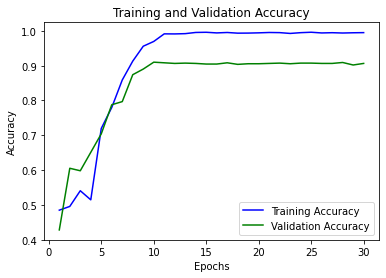

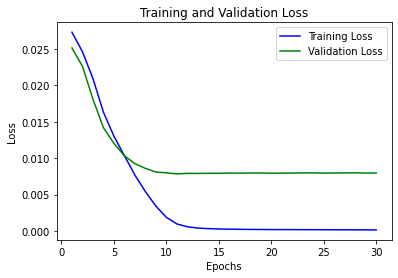

In [127]:
##defining a function to plot accuracy and loss function for training and validating data to have a better comparison
def Training_and_validation_plot(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.plot(epochs, acc, 'b', label = 'Training Accuracy')
    plt.plot(epochs, val_acc, 'g', label = 'Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.figure()
    plt.plot(epochs, loss, 'b', label = 'Training Loss')
    plt.plot(epochs, val_loss, 'g', label = 'Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
Training_and_validation_plot(history)

Text(4, 1.1100719690322876, '0.9100')

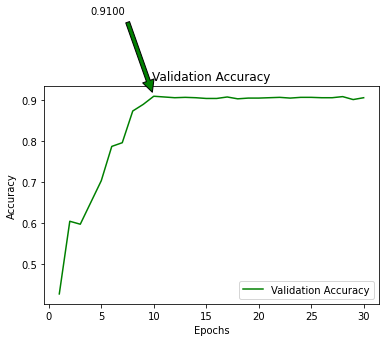

In [128]:
#########highest validation accuracy point
val_acc = history.history['val_accuracy']
acc = history.history['accuracy']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, val_acc, 'g', label = 'Validation Accuracy')
plt.title('Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
y_arrow = max(val_acc)
x_arrow = val_acc.index(y_arrow) + 1
plt.annotate(str(y_arrow)[:6],
             (x_arrow, y_arrow),
             xytext=(x_arrow - 6, y_arrow + 0.2),
             arrowprops=dict(facecolor='green',shrink=0.05))

#### 1.9. Evaluating the model performance (confusion and performance matrix)

Since Dataset is highly imbalanced with entities "restaurant_type" and "party_size_number" holding more than 50% of dataset, a better inspection of result wold be using confusion matrix for each entity rather than a combined matrix and checking performance matrix corresponding to the same.

In [129]:
### defining function for confusion matrix plotting confusion matirx for each entity individually.
def conf_matrix(cm, entityid):
    entityname = index2entity[entityid]
    print("Tag name: {}".format(entityname))
    print(cm[entityid])
    tn, fp, fn, tp = cm[entityid].ravel()
    entity_accuracy = (tp + tn) / (tn + fp + fn + tp)
    print("Entity accuracy: {:.2f} \n".format(entity_accuracy))

matrix = multilabel_confusion_matrix(y_test.flatten(), y_pred.flatten())

conf_matrix(matrix, 0)
conf_matrix(matrix, 1)
conf_matrix(matrix, 2)
conf_matrix(matrix, 3)
conf_matrix(matrix, 4)
conf_matrix(matrix, 5)
conf_matrix(matrix, 6)
conf_matrix(matrix, 7)
conf_matrix(matrix, 8)
conf_matrix(matrix, 9)
conf_matrix(matrix, 10)
conf_matrix(matrix, 11)
conf_matrix(matrix, 12)
conf_matrix(matrix, 13)

Tag name: restaurant_type
[[1365  129]
 [   9 3233]]
Entity accuracy: 0.97 

Tag name: country
[[4628   12]
 [  34   62]]
Entity accuracy: 0.99 

Tag name: timeRange
[[4447   80]
 [ 108  101]]
Entity accuracy: 0.96 

Tag name: sort
[[4684    0]
 [   0   52]]
Entity accuracy: 1.00 

Tag name: spatial_relation
[[4653    0]
 [   1   82]]
Entity accuracy: 1.00 

Tag name: poi
[[4678   18]
 [  15   25]]
Entity accuracy: 0.99 

Tag name: cuisine
[[4653   22]
 [  19   42]]
Entity accuracy: 0.99 

Tag name: facility
[[4692    1]
 [   0   43]]
Entity accuracy: 1.00 

Tag name: restaurant_name
[[4583   44]
 [  42   67]]
Entity accuracy: 0.98 

Tag name: served_dish
[[4639   11]
 [  59   27]]
Entity accuracy: 0.99 

Tag name: city
[[4475  102]
 [ 103   56]]
Entity accuracy: 0.96 

Tag name: party_size_description
[[4626   24]
 [  64   22]]
Entity accuracy: 0.98 

Tag name: party_size_number
[[4418    2]
 [   0  316]]
Entity accuracy: 1.00 

Tag name: state
[[4561   21]
 [  12  142]]
Entity accura

In [130]:
for entityid in range(0,13):
    entityname = index2entity[entityid]
    print("Tag name: {}".format(entityname))
print('\n')
print("Precision, Recall, F1")
cr = classification_report(y_test.flatten(), y_pred.flatten())
print(cr)

Tag name: restaurant_type
Tag name: country
Tag name: timeRange
Tag name: sort
Tag name: spatial_relation
Tag name: poi
Tag name: cuisine
Tag name: facility
Tag name: restaurant_name
Tag name: served_dish
Tag name: city
Tag name: party_size_description
Tag name: party_size_number


Precision, Recall, F1
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      3242
           1       0.84      0.65      0.73        96
           2       0.56      0.48      0.52       209
           3       1.00      1.00      1.00        52
           4       1.00      0.99      0.99        83
           5       0.58      0.62      0.60        40
           6       0.66      0.69      0.67        61
           7       0.98      1.00      0.99        43
           8       0.60      0.61      0.61       109
           9       0.71      0.31      0.44        86
          10       0.35      0.35      0.35       159
          11       0.48      0.26      0.33   

As per above confusion matrix for individual entity, accuracy for each entity is good on test data.

Since, as described above dataset is highly imbalanced with "restaurant_size" and "party_size_number" contributing to 50% of dataset. And Accuracy is calculated as correct prediction from the total prediction, so it will always be good for class with high value of data points. Hence Accuracy is not considered a good parameter for understanding effectiveness of model. While F1 score combines both recall and precision via harmonic mean and is considered a good performance matrix for imbalanced dataset.

Here we can see for 9,10 and 11 f-1 score is even less than 50%,, which corresponds to served_dish, city and party_size_description and these entties do have very less ouccurance in dataset, so there is high possibility that prediction for these entties could be false as per training the model.

### 2. LSTM (Long Short Term Memory network) Model:

#### 2.1. Pre-processing-Tokenizing data using Tokenizer from Keras:

HereI am using Tokenizer class from keras preprocessing to convert our text labels into a sequence of integers to feed to our model.

I have passed num_words argument into Tokenizer class which represents the count of words based on the  frequency of words in dataset, hence I have provided value =2316, since unique values of words in our dataset is 2316 as evaluated above.

In [131]:
tok_lstm = Tokenizer(num_words=2316)
tok_lstm.fit_on_texts(data['value'])
X = tok_lstm.texts_to_sequences(data['value'])

In [132]:
### applying padding to x for balancing shape and size
X = pad_sequences(X)
X

array([[  0,   0,   0, ...,   3, 256, 114],
       [  0,   0,   0, ...,   0,   0,   1],
       [  0,   0,   0, ...,   0,   0,   5],
       ...,
       [  0,   0,   0, ...,   0,  10,   1],
       [  0,   0,   0, ...,   0, 172, 730],
       [  0,   0,   0, ...,   0,   0,   0]], dtype=int32)

In [133]:
#encoding the entity class
le = LabelEncoder()
Y = le.fit_transform(data['entity'])
Y

array([ 7,  8, 12, ...,  8, 13,  9])

NOTE : For LSTM, I'm not implementing One hot encoding on our labels, to experiement based on integer values.

#### 2.2. Model Implementation with 70%/30% | train/test ratio and 90%/10% | train/validation ratio

In [134]:
########splitting test and train data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.30, random_state=2)

In [135]:
#define vocabulary
vocabulary = len(tok_lstm.word_index)
print("numbe of unique words:", vocabulary)
output_length = le.classes_.shape[0]
print("output length: ", output_length)

numbe of unique words: 2373
output length:  14


In [136]:
### creating the model
input_shape = X_train.shape[1]
i = Input(shape=(input_shape))
x= Embedding(vocabulary+1,10)(i)
x = LSTM(10, return_sequences = True)(x)
x = Flatten()(x)
x = Dense(output_length, activation = "softmax")(x)
model3 = Model(i,x)

In [137]:
#compiling the model
model3.compile(loss="sparse_categorical_crossentropy",optimizer='adam',metrics=['accuracy'])

In [138]:
history = model3.fit(X_train,y_train,epochs=30,validation_split=0.1)

Epoch 1/30
127/127 [==============================] - 4s 14ms/step - loss: 2.4762 - accuracy: 0.1749 - val_loss: 2.3776 - val_accuracy: 0.2156
Epoch 2/30
127/127 [==============================] - 1s 9ms/step - loss: 2.3164 - accuracy: 0.2420 - val_loss: 2.2223 - val_accuracy: 0.2333
Epoch 3/30
127/127 [==============================] - 1s 7ms/step - loss: 2.0280 - accuracy: 0.3971 - val_loss: 1.8088 - val_accuracy: 0.4689
Epoch 4/30
127/127 [==============================] - 1s 7ms/step - loss: 1.5841 - accuracy: 0.5171 - val_loss: 1.3952 - val_accuracy: 0.5933
Epoch 5/30
127/127 [==============================] - 1s 7ms/step - loss: 1.2281 - accuracy: 0.6381 - val_loss: 1.1229 - val_accuracy: 0.7111
Epoch 6/30
127/127 [==============================] - 1s 7ms/step - loss: 0.9815 - accuracy: 0.7514 - val_loss: 0.9130 - val_accuracy: 0.7911
Epoch 7/30
127/127 [==============================] - 1s 7ms/step - loss: 0.7888 - accuracy: 0.8308 - val_loss: 0.7632 - val_accuracy: 0.7978
Epoch

#### 2.3. Choice of Loss function, Optimiser and Hyperparameters

For Loss function we have used "sparse_categorical_crossentropy" loss function which is considered best for multi-label classification problem. Since we haven't performed one-hot encoding on our entity label, "sparse_categorical_crossentropy" can perform the same calculation for cross entropy error without requiring one hot encoding for target class and will help to save significant memory.

For Optimiser we have used the same "Adam" as for BiLSTM model since it is best fit for multi-label classification.

Softmax function is used in the activation layer to predict multinomial probability distribution for multilabel classification. Softmax is considered better than Sigmoid function for multilabel classification where is sigmoid is better for binary classification, and hence Softmax function.

#### 2.3. Model Implementation with 90%/10% | train/test ratio and 70%/30% | train/validation ratio

In [139]:
########splitting test and train data
X_train1, X_test1, y_train1, y_test1 = train_test_split(X, Y, test_size=0.10, random_state=2)

In [140]:
### creating the model
input_shape1 = X_train1.shape[1]
i1 = Input(shape=(input_shape1))
x1= Embedding(vocabulary+1,10)(i1)
x1 = LSTM(10, return_sequences = True)(x1)
x1 = Flatten()(x1)
x1 = Dense(output_length, activation = "softmax")(x1)
model4 = Model(i1,x1)

In [141]:
#compiling the model
model4.compile(loss="sparse_categorical_crossentropy",optimizer='adam',metrics=['accuracy'])

In [142]:
history1 = model4.fit(X_train1,y_train1,epochs=30,validation_split=0.3)

Epoch 1/30
127/127 [==============================] - 4s 12ms/step - loss: 2.4563 - accuracy: 0.2060 - val_loss: 2.3535 - val_accuracy: 0.2152
Epoch 2/30
127/127 [==============================] - 1s 7ms/step - loss: 2.2670 - accuracy: 0.2303 - val_loss: 2.1537 - val_accuracy: 0.2643
Epoch 3/30
127/127 [==============================] - 1s 8ms/step - loss: 1.9768 - accuracy: 0.3176 - val_loss: 1.8250 - val_accuracy: 0.3347
Epoch 4/30
127/127 [==============================] - 1s 7ms/step - loss: 1.6680 - accuracy: 0.3898 - val_loss: 1.5922 - val_accuracy: 0.4103
Epoch 5/30
127/127 [==============================] - 1s 7ms/step - loss: 1.4733 - accuracy: 0.4601 - val_loss: 1.4288 - val_accuracy: 0.4870
Epoch 6/30
127/127 [==============================] - 1s 7ms/step - loss: 1.3043 - accuracy: 0.6070 - val_loss: 1.2928 - val_accuracy: 0.5372
Epoch 7/30
127/127 [==============================] - 1s 7ms/step - loss: 1.1430 - accuracy: 0.7086 - val_loss: 1.1331 - val_accuracy: 0.6844
Epoch

For LSTM also, splitting dataset as 70%/30% performs better compared to 90%/10% , so further evaluation of model will be done on 70%/30% trained model.

#### 2.4. Testing the model

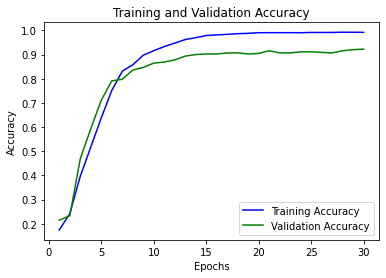

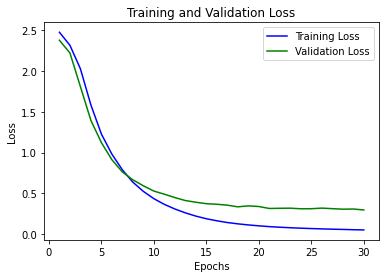

In [143]:
Training_and_validation_plot(history)

Text(42, 1.1222221970558166, '0.9222')

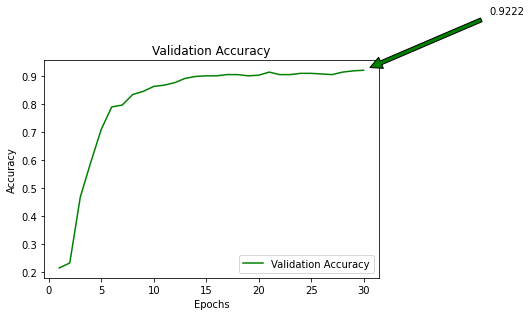

In [144]:
#########highest validation accuracy point
val_acc = history.history['val_accuracy']
acc = history.history['accuracy']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, val_acc, 'g', label = 'Validation Accuracy')
plt.title('Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
y_arrow = max(val_acc)
x_arrow = val_acc.index(y_arrow) + 1
plt.annotate(str(y_arrow)[:6],
             (x_arrow, y_arrow),
             xytext=(x_arrow + 12, y_arrow + 0.2),
             arrowprops=dict(facecolor='green',shrink=0.05))

In [145]:
###accuracy on test dataset
y_pred1 = model3.predict(X_test)
y_pred1=(y_pred1 > 0.5)
accr = model3.evaluate(X_test,y_test)
lstm_acc=accr[1]
print('Test set\n   Accuracy: {:0.3f}'.format(accr[1]))

61/61 [==============================] - 0s 3ms/step - loss: 0.4380 - accuracy: 0.8775
Test set
   Accuracy: 0.877


In [146]:
## plotting confusion matrix for each enetity as per function created above:
rounded_labels=np.argmax(y_pred1, axis=1)
rounded_labels[1]
matrix = multilabel_confusion_matrix(y_test.flatten(), rounded_labels)

conf_matrix(matrix, 0)
conf_matrix(matrix, 1)
conf_matrix(matrix, 2)
conf_matrix(matrix, 3)
conf_matrix(matrix, 4)
conf_matrix(matrix, 5)
conf_matrix(matrix, 6)
conf_matrix(matrix, 7)
conf_matrix(matrix, 8)
conf_matrix(matrix, 9)
conf_matrix(matrix, 10)
conf_matrix(matrix, 11)
conf_matrix(matrix, 12)
conf_matrix(matrix, 13)

Tag name: restaurant_type
[[1607  159]
 [   6  154]]
Entity accuracy: 0.91 

Tag name: country
[[1820    0]
 [  42   64]]
Entity accuracy: 0.98 

Tag name: timeRange
[[1855    1]
 [  31   39]]
Entity accuracy: 0.98 

Tag name: sort
[[1876    0]
 [   0   50]]
Entity accuracy: 1.00 

Tag name: spatial_relation
[[1819    1]
 [   7   99]]
Entity accuracy: 1.00 

Tag name: poi
[[1601    4]
 [   0  321]]
Entity accuracy: 1.00 

Tag name: cuisine
[[1877   10]
 [  16   23]]
Entity accuracy: 0.99 

Tag name: facility
[[1810   10]
 [  30   76]]
Entity accuracy: 0.98 

Tag name: restaurant_name
[[1521    6]
 [   0  399]]
Entity accuracy: 1.00 

Tag name: served_dish
[[1833   11]
 [  47   35]]
Entity accuracy: 0.97 

Tag name: city
[[1869    0]
 [   1   56]]
Entity accuracy: 1.00 

Tag name: party_size_description
[[1842    0]
 [   1   83]]
Entity accuracy: 1.00 

Tag name: party_size_number
[[1758    7]
 [  10  151]]
Entity accuracy: 0.99 

Tag name: state
[[1740    1]
 [  19  166]]
Entity accura

In [147]:
### Performance Matrix
for entityid in range(0,13):
    entityname = index2entity[entityid]
    print("Tag name: {}".format(entityname))
print('\n')
print("Precision, Recall, F1")
print('\n')
CR=classification_report(y_test, rounded_labels)
print(CR)
print('\n')

Tag name: restaurant_type
Tag name: country
Tag name: timeRange
Tag name: sort
Tag name: spatial_relation
Tag name: poi
Tag name: cuisine
Tag name: facility
Tag name: restaurant_name
Tag name: served_dish
Tag name: city
Tag name: party_size_description
Tag name: party_size_number


Precision, Recall, F1


              precision    recall  f1-score   support

           0       0.49      0.96      0.65       160
           1       1.00      0.60      0.75       106
           2       0.97      0.56      0.71        70
           3       1.00      1.00      1.00        50
           4       0.99      0.93      0.96       106
           5       0.99      1.00      0.99       321
           6       0.70      0.59      0.64        39
           7       0.88      0.72      0.79       106
           8       0.99      1.00      0.99       399
           9       0.76      0.43      0.55        82
          10       1.00      0.98      0.99        57
          11       1.00      0.99      0.99 

Here for LSTM, F-1 Score is better even for the entities for which it was very less in BiLSTM. But effectiveness of the evaluation of LSTM is less since the model was trained only with LSTM while for BiLSTM, I have implemnted Time Distribution layer, Dropout layer which will help in increasing the effectiveness of the model and will be evaluated below.

### Comparing results from both LSTM and BiLSTM Model Implementation

In [148]:
### test accuracy comparison of both models 
results = PrettyTable()
print("Comparing results from  LSTM and BiLSTM Model")
results.field_names = ["Model", "Accuracy"]

results.add_row(["LSTM model", round(lstm_acc,3)])
results.add_row(["BiLSTM model",  round(accuracy,2)])

print(results)

Comparing results from  LSTM and BiLSTM Model
+--------------+----------+
|    Model     | Accuracy |
+--------------+----------+
|  LSTM model  |  0.877   |
| BiLSTM model |   0.9    |
+--------------+----------+


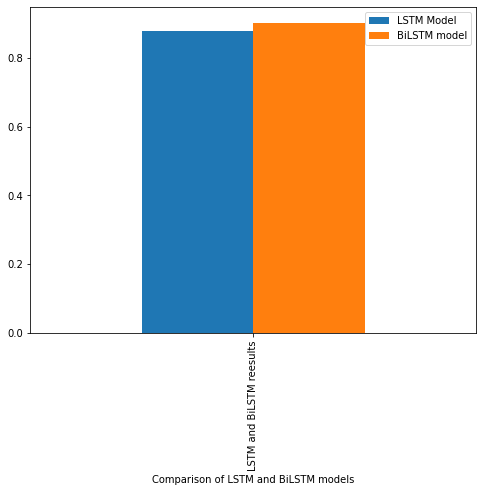

In [149]:
### plotting accuracy comparison bar graph
final_acc = [['LSTM and BiLSTM reesults', lstm_acc, accuracy]]
final_acc = pd.DataFrame (final_acc, columns = ['Comparison of LSTM and BiLSTM models','LSTM Model', 'BiLSTM model'])
final_acc.set_index("Comparison of LSTM and BiLSTM models",drop=True,inplace=True)
final_acc.plot(kind='bar',figsize=(8, 6)).legend(bbox_to_anchor=(1, 1))

### Discussion on better performing model, reasons and any further adjustment required

As indicated in starting that BiLSTM has perform better compared to LSTM because of few  reasons as mention below:

1. BiLSTM trains from both past and future while LSTM trains from only future. So, prediction for BiLSTM will be better since it does have information from past as-well.

2. Time distributed layer : For BiLSTM, I have added time distributed layer which processes onje input at a time and hence simplies the network/ model and helped in better learning for model.

3. Dropout Layer: I have implemented Dropout layer in BiLSTM model unlike LSTM which helped model to tackle over-ffiting of data more efficiently.

"sparse_categorical_crossentropy" loss function is considered best for multi-label classification problems which I have sued in LSTM model, but I think if I would have used the same for BiLSTM aswell instead of "mean_squared_error" loss function, the accuracy/ F-1 score would have been better.

### Name Entity Recognization example using BiLSTM

In [150]:
## Sentence example
sent = "book midday at halal place for five at a bakery or restaurant in Sugarville"

In [151]:
tok = re.compile(f"([{string.punctuation}“”¨«»®´·º½¾¿¡§£₤‘’])") ### removing punctuation
sent = tok.sub(r"  ", sent).split() ## tokenization
sent = [x for x in sent if x not in stop_words] ### removing stop-words
value2index["--PADDING--"]=1 
p_sent = sent + [value2index["--PADDING--"]] * (long_sent - len(sent)) ## padding sentence
p_sent = [value2index.get(w, 0) for w in p_sent]
pred = final_model.predict(np.array([p_sent])) ## feeding into model
pred = np.argmax(pred, axis=-1)

ret = ""
for a, b in zip(sent, pred[0]):
    ret = ret + "{:15}: {:5}".format(a, index2entity[b]) + "\n"
print(ret)

book           : restaurant_type
midday         : timeRange
halal          : cuisine
place          : restaurant_type
bakery         : restaurant_type
restaurant     : restaurant_type
Sugarville     : city 



Here, model was able to predict timerange, cuisine,restaurant_type and city perfectly. But due to small and imbalanced dataset model had predicted book incorrectly as restaurant_type.

### Can the chatbot components you experimented with fulfil their purpose? 

It is important for Name Entity Recognization is to understand the context of the text and to extract entities as per the context. BiLSTM model is very efficient when it comes to understanding the information since this model learn from past and future information and hence was very effective to dintiguish entities as per the context of the sentence, as discribed above with example. 

Also the accuracy for the BiLSTM model was better on test data as compared to LSTM, so overall, as per above experiements I was able to extract different entities from both LSTM and BiLSTM models, but more effectively with BiLSTM.

###  What is good enough accuracy?

Accuracy from both the models is very good. It is because of the size of the data provided to model is very limited. Also there are multiple entities in small dataset which is also very imbalanced, hence inspite of having good accuracy the F-1 score for both models is very low. And for imbalanced dataset F-1 score is more important parameter to consider the performance as compared to accuracy.

### If any of the models did not perform well, what is needed to improve?

Both the models have good performance, since the size of the data was very limited, so the prediction was expected to be limited as well. But LSTM can be considered as having bad performance as compared to BiLSTM.

I could have experimented around adding different layers inside models or tuning haperparameters to have a better performance as below :

1. Dropout layer : I could have implemnted Dropout layer with LSTM model input layer the way I have added in BiLSTM model. It would have helped to reduce overfitting during training becuase it helps in bypassing neurons randomly which would have reduced the sensitivity. 
2. Activation function : Instead of using softmax activation function, I could have experimented with rectifier activation function which is considered most efficient and popular activation function.

### If any of the models performed really well, could you make it more efficient and sacrifice some quality?

The prediction for BiLSTM was good because of its both side learning. Secondly Time Distributed wrapper layer helped to further simplifies the model by processing one step at a time.

I was planning to add linear CRF model layer to BiLSTM model as it tries to create relationship between tags (entities) in NER classification problems because it assumes that the tag for any word also depends on the tag of previous word, which would helped me to have a better prediction and would have made my Name entity Recognization more efficient. It might have increase the duration of training and reduce accuracy but prediction would have been more efficient.

## Dialogue Flow Manager

Here, I am implementing Rule based chatbot where I have created different functions for different type of expected questions from user. We have stored sample questions and expected outputs in different variables. For queries related to restaurant I have used the same intents which were implemented by other team-mate for intent classification and I have worked on the conversation of those intents only. 

Also, Our dataset for intent classification doesn't had any response stored in it for queries. So I had wrote the responses manually as per intents and stored the same in a text file. Same is attached inside zip folder.

For responses related to restaurant recommendation and food recommendation, I have used cosine similarity for which user will response from the list of sentences stored in response file such that responses with highest cosine similarity with vectorised word from Input queries will be responded by the chatbot. 

I have named this chatbot "Chatterchef" for better user experience.

#### 1. Working with Greetings and general conversation

First I am going to work on the greetings for the user and how chatbot is going to understand the greetings. Here we are taking synonyms of Hello word, so that chatbot can understand any word under that list and provide corresponding response.

In [152]:
# taking synonyms of hello from wordnet synonyms set and appending in a list
syn = []
for s in wordnet.synsets('hello'):
    for l in s.lemmas():
        lname = re.sub(r'\[[0-9]*\]', ' ', l.name())
        lname = re.sub(r'\s+', ' ', l.name())
        syn.append(lname)

In [153]:
# taking greeting inputs and corresponding possible responses from chatbot
greetings = ['hi','hey', 'hello', 'whats up', 'good evening', 'good morning', 'hey there']
# concatenating the synonyms and the inputs for greeting
greetings = greetings + syn
# greeting responses by the bot
greetings_resp = ['Hi! How can I help you?',
                      'Hello there! So please what do you want to know?',
                      'Hi, How can I assist you today?']

In [154]:
### taking some more basic converation
convos = ['how are you', 'how are you doing today', 'you good ?']
# possible responses by chatbot
convos_resp = ['Great! what about you?', 'Just having a busy day :( wbu??', 'Just enjoying my work :)']
# possible replies by user
convos_user = ['great', 'i am fine', 'fine', 'good', 'super', 'superb', 'super great', 'nice']

In [155]:
# other basic qus and ans related to chatbot (chatterchef)
ques_ans = {'what are you': 'I am a restaurant bot. Here to help you for food and restaurant recommendation :3',
                    'who are you': 'I am a restaurant bot. Here to help you for food and restaurant recommendation :3',
                    'what can you do': 'Recommending restaurant and food!'}

#### 2. Preprocessing on responses
Loading response file for different queries from user and preprocessing on it with removing special characters and building responses into different sentences and words. Lemmetizing and removing punctuation from words to apply cosine similarity on the same.

In [156]:
## Loading responses file
with open ('/home/studio-lab-user/NLP-2022/Coursework/restaurant_response_dataset.txt', 'r') as f:
    d_data = f.read()

In [157]:
# Lower casing the data
t_data = d_data.lower()

In [158]:
# removing secial characters from response data
t_data = re.sub(r'\[[0-9]*\]', ' ', t_data)
t_data = re.sub(r'\s+', ' ', t_data)

In [159]:
# extracting sentences from the response data
sentences = nltk.sent_tokenize(t_data)
# extracting words from the response data
words = nltk.word_tokenize(t_data)

In [160]:
# applying lemmatization on words
lem = nltk.stem.WordNetLemmatizer()
def per_lem(tokens):
    return [lem.lemmatize(token) for token in tokens]

In [161]:
# punctuation
rem_punc = dict((ord(p), None) for p in string.punctuation)

In [162]:
# method for pre-processing as per above functions
def proc_data(doc):
    return per_lem(nltk.word_tokenize(doc.lower().translate(rem_punc)))

In [163]:
# removing punctuation
def punc_rem(str):
    punc = r'''!()-[]{};:'"\,<>./?@#$%^&*_~'''
    no_punc = ''

    for c in str:
        if c not in punc:
            no_punc = no_punc + c

    return no_punc

#### 3. Creating different function for greetings, general respomnses and restaurant related responses

Here I have created different functions to fetch for different scenarios inputs expected from customer and how and from where to provide corresponing responses via chatbot

In [164]:
# function for greetings
def greeting(hello):
    if punc_rem(hello.lower()) in greetings:
        return random.choice(greetings_resp)

In [165]:
# function for responsing
def convo_resp(str):
    if punc_rem(str.lower()) in convos:
        return random.choice(convos_resp)

In [166]:
# function for qus and ans
def qus_ans(str):
    if punc_rem(str.lower()) in ques_ans:
        return ques_ans[punc_rem(str.lower())]

In [167]:
# function to fetch response from response file
def recommendation(user):
    bot_resp = ''
    sentences.append(user)

    w_vect = TfidfVectorizer(tokenizer=proc_data, stop_words='english')
    word_vect = w_vect.fit_transform(sentences)
    sim_vect = cosine_similarity(word_vect[-1], word_vect)
    sim_sent = sim_vect.argsort()[0][-2]

    mat_vect = sim_vect.flatten()
    mat_vect.sort()
    vect_mat = mat_vect[-2]

    if vect_mat is 0:
        bot_resp = bot_resp + 'Sorry, I can\'t help you with this. You can check out our website for further details. '
        return bot_resp
    else:
        bot_resp = bot_resp + sentences[sim_sent]
        return bot_resp

In [168]:
# chatting with the chatbot -->
chat = True
print('Hi! I am the restaurant bot representative: Chatterchef. You can ask me for restaurant and food recommendation and I shall try my best to answer them: ')
while chat:
    u_ip = input().lower()
    u_ip = punc_rem(u_ip)
    if u_ip != 'bye':
        if u_ip == 'thanks' or u_ip == 'thank you very much' or u_ip == 'thank you':
            chat = False
            print('Chatterchef: happy to help ! (And WELCOME! :D)')
        elif u_ip in convos_user:
            print('That\'s nice! How can I help you?')
            continue
        else:
            if greeting(u_ip) is not None:
                print('Chatterchef: ' + greeting(u_ip))
            elif convo_resp(u_ip) is not None:
                print('Chatterchef: ' + convo_resp(u_ip))
            elif qus_ans(u_ip) is not None:
                print('Chatterchef: ' + qus_ans(u_ip))
            else:
                print('Chatterchef: ', end='')
                print(recommendation(u_ip))
                sentences.remove(u_ip)
    else:
        continue_chat = False
        print('Chatterchef: Bye, take care, stay home and stay safe!')

Hi! I am the restaurant bot representative: Chatterchef. You can ask me for restaurant and food recommendation and I shall try my best to answer them: 


 hi


Chatterchef: Hi! How can I help you?


 how are you


Chatterchef: Great! what about you?


 good. want to book a table


Chatterchef: yes sure, please for how many people should i book the table ?


 3, 8:00PM?


Chatterchef: i will be happy to take reservation for you.


 is reservation confirm ?


Chatterchef: your reservation is confirm, happy dining.


 thanks


Chatterchef: happy to help ! (And WELCOME! :D)


#### References:

1. https://machinelearningmastery.com/how-to-choose-loss-functions-when-training-deep-learning-neural-networks/ https://machinelearningmastery.com/softmax-activation-function-with-python/#:~:text=The%20softmax%20function%20is%20used%20as%20the%20activation%20function%20in,more%20than%20two%20class%20labels.

2. https://www.kaggle.com/datasets/swapnilpote/restaurant-chatbot-dataset-intent-entity

3. https://stackoverflow.com/questions/43035827/whats-the-difference-between-a-bidirectional-lstm-and-an-lstm

4. https://deepdatascience.wordpress.com/2016/11/18/which-lstm-optimizer-to-use/

5. https://blog.dominodatalab.com/named-entity-recognition-ner-challenges-and-model

6. https://github.com/JinnJarBurger/Rule-based-chatbot/

7. https://stackoverflow.com/questions/4371231/removing-punctuation-from-python-list-items

8. https://machinelearningmastery.com/timedistributed-layer-for-long-short-term-memory-networks-in-python/